In [1]:
from preprocess_images import *
import pandas as pd
import os, glob
import cv2 as cv
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
# This is needed to display the images.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (9, 9)

In [3]:
# original images
PATH_TO_ANNO = '../annotations/'
ANNO_TABLE = 'test_labels.csv'
PATH_TO_IMAGES = '../images/'
PATH_TO_RESIZED_IMAGES = '../images/resized/test/'
# augmented images
PATH_TO_AUG_IMAGES = 'images/test/'

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_ANNO, ANNO_TABLE))

In [5]:
df.head(6)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,DSCF1029.JPG,3648,2736,bus,129,1648,1400,2381
1,DSCF1029.JPG,3648,2736,bus,1456,1076,2578,1910
2,DSCF1029.JPG,3648,2736,bus,2552,826,3610,1630
3,DSCF1105.JPG,3648,2736,bus,1090,1016,2402,1771
4,DSCF1142.JPG,3648,2736,bus,914,1200,1800,1588
5,DSCF1142.JPG,3648,2736,bus,2010,1211,2888,1599


In [6]:
imresize_to_300x225(PATH_TO_IMAGES, PATH_TO_RESIZED_IMAGES, df=df)

In [7]:
# 6 resized train images
len(glob.glob(PATH_TO_RESIZED_IMAGES + '*.JPG'))

6

In [8]:
# new scaled df
df.head(6)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,s_DSCF1029.JPG,300,225,bus,10,135,115,195
1,s_DSCF1029.JPG,300,225,bus,119,88,212,157
2,s_DSCF1029.JPG,300,225,bus,209,67,296,134
3,s_DSCF1105.JPG,300,225,bus,89,83,197,145
4,s_DSCF1142.JPG,300,225,bus,75,98,148,130
5,s_DSCF1142.JPG,300,225,bus,165,99,237,131


In [9]:
[filenames_s, images, bboxes] = get_images_bboxes(df=df, path_to_images=PATH_TO_RESIZED_IMAGES)

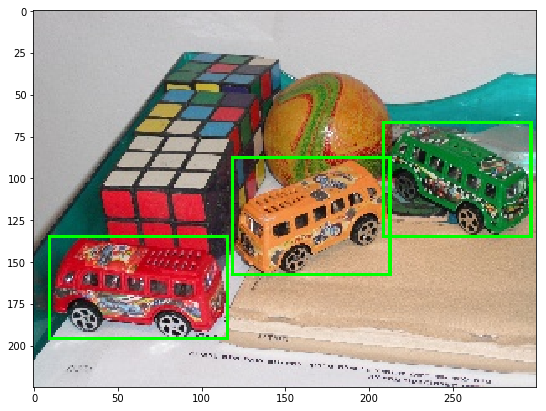

In [10]:
imshow_bbox(images, bboxes, 1)

In [11]:
sometimes = lambda aug: iaa.Sometimes(0.8, aug)
def empty_seq():
    seq = iaa.Sequential()
    seq_det = seq.to_deterministic()
    return seq_det

def seq_det_aug():
    seq = iaa.Sequential([iaa.Multiply(mul=(0.75, 1.25)),
                    iaa.Add(value=(-25,25)),
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.OneOf([
                    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
                    iaa.AdditiveGaussianNoise(scale=(0, 0.02*255))]),
                    sometimes(iaa.Affine(
                            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                            rotate=(-45, 45), # rotate by -45 to +45 degrees
                            shear=(-16, 16), # shear by -16 to +16 degrees
                            order=3, # use nearest neighbour or bilinear interpolation (fast)
                            cval=0, # if mode is constant, use cval 0
                        ))])
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    return seq_det

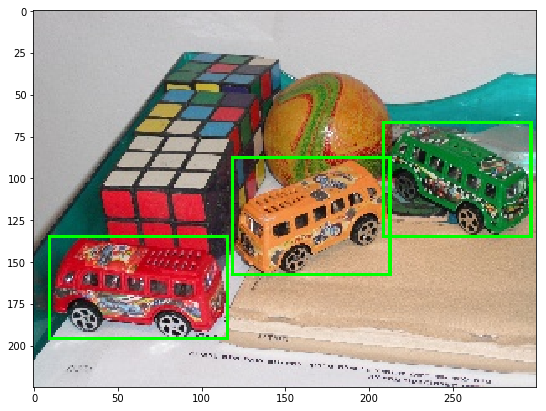

In [12]:
batches_to_concat = []
batch = 1
for i in range(batch):
    if (i == 0):
        seq = empty_seq()
    else:
        seq = seq_det_aug()
        
    images_aug = seq.augment_images(images)
    bboxes_aug = seq.augment_bounding_boxes(bboxes)
    filename_aug_batch = [str(i) + '_' + f for f in filenames_s]
    df_batch = imwrite_aug_ssd(images_aug, filename_aug_batch, bboxes_aug, PATH_TO_AUG_IMAGES)
    batches_to_concat.append(df_batch.copy())
    imshow_bbox(images_aug, bboxes_aug, 1)

df_aug = pd.concat(batches_to_concat)
df_aug.to_csv(os.path.join(PATH_TO_ANNO, 'aug_test_labels.csv'), index=None)

In [13]:
print('Num of objects in the training set:', len(df_aug['filename']))
print('Num of images in the training set:', len(list(set(df_aug['filename'].tolist()))))

Num of objects in the training set: 10
Num of images in the training set: 6


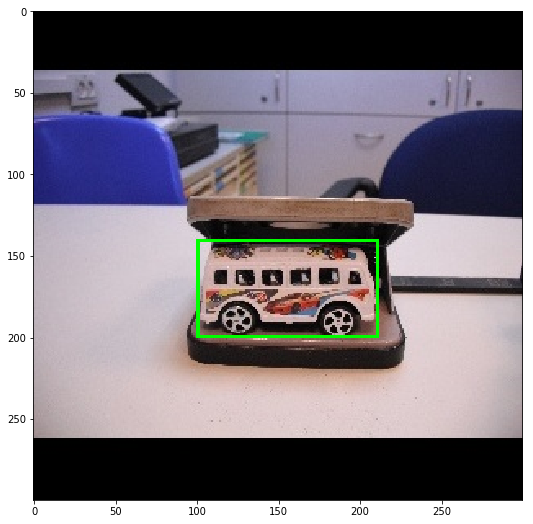

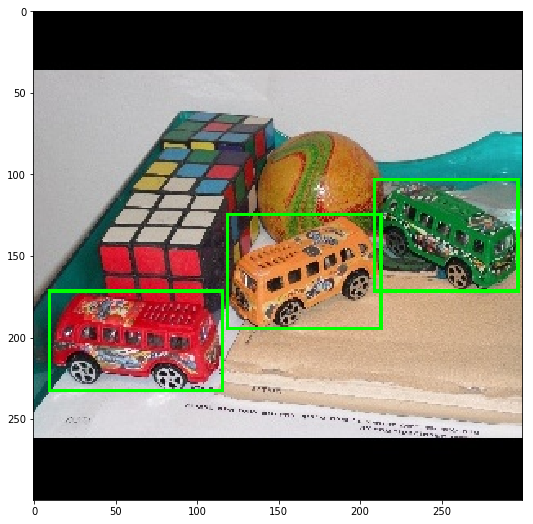

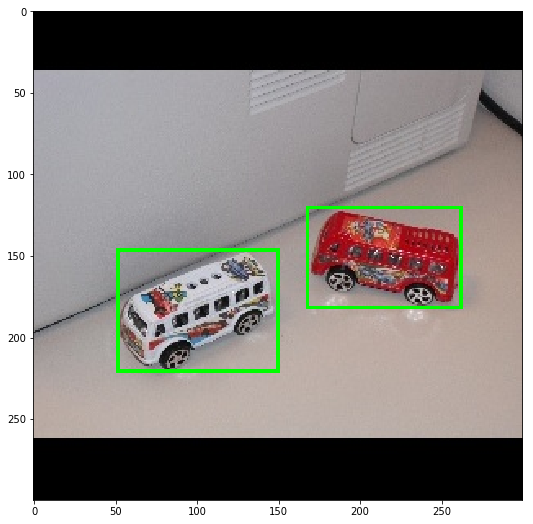

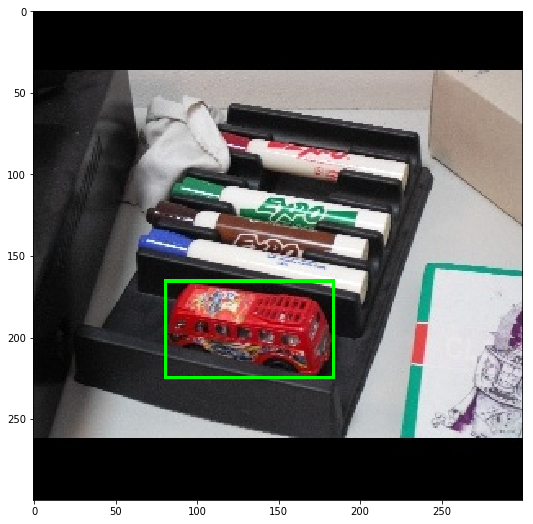

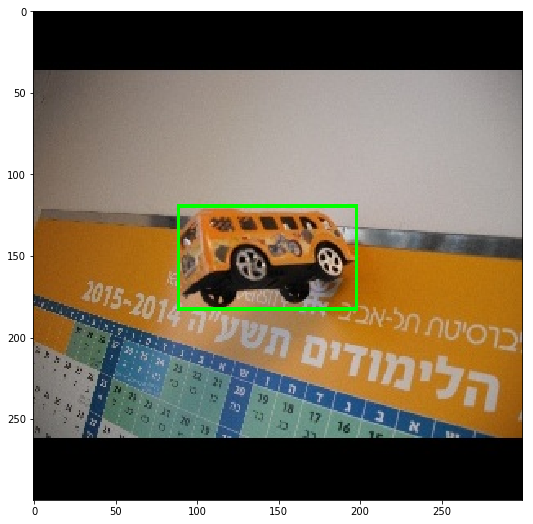

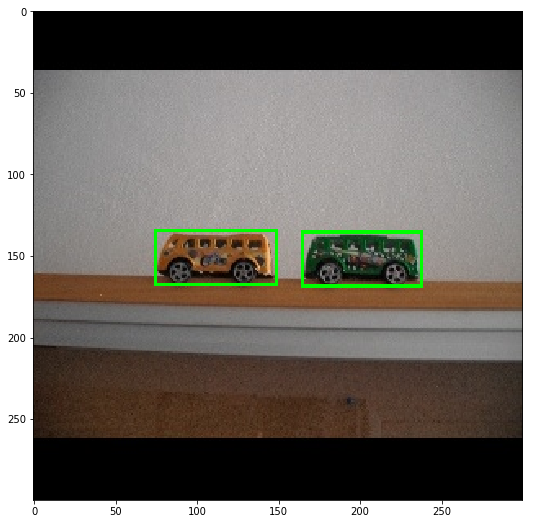

In [14]:
[_, img_t, bb_t] = get_images_bboxes(df=df_aug, path_to_images=PATH_TO_AUG_IMAGES)
imshow_bbox(img_t, bb_t)